In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

import missingno as msno
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression 

#----------------------------------------------
data=pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv").iloc[:,:]
X=data.iloc[:,:-1]
Y=data['SalePrice']
#-----------------------------------------
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=555,shuffle=True)
#------------------------------------
X_train=X_train.drop(["Id","Alley","PoolQC",'Fence','MiscFeature'],axis=1)
X_test=X_test.drop(["Id","Alley","PoolQC",'Fence','MiscFeature'],axis=1)
#-------------------------------------

In [2]:
columns_na=[column_name for column_name in X_train.columns if X_train[column_name].isnull().sum()>=1]
print(columns_na)

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


In [3]:
num_columns=[column_name for column_name in X_train.columns if X_train[column_name].dtypes!='object']
print(num_columns)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [4]:
disc_columns=[column_name for column_name in num_columns if len(X_train[column_name].unique())<25]
print(disc_columns)

['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [5]:
#Separando nome das variáveis do tipo ano/data:
date_columns=[column_name for column_name in X_train.columns if 'Yr' in column_name or 'Year' in column_name]
print(date_columns)

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


In [6]:
cat_columns=[column_name for column_name in X_train.columns if X_train[column_name].dtypes=='object']
print(cat_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [7]:
for var in cat_columns:
    print('A variável {} tem {} categorias.'.format(var, len(X_train[var].unique())))

A variável MSZoning tem 5 categorias.
A variável Street tem 2 categorias.
A variável LotShape tem 4 categorias.
A variável LandContour tem 4 categorias.
A variável Utilities tem 2 categorias.
A variável LotConfig tem 5 categorias.
A variável LandSlope tem 3 categorias.
A variável Neighborhood tem 25 categorias.
A variável Condition1 tem 9 categorias.
A variável Condition2 tem 7 categorias.
A variável BldgType tem 5 categorias.
A variável HouseStyle tem 8 categorias.
A variável RoofStyle tem 6 categorias.
A variável RoofMatl tem 8 categorias.
A variável Exterior1st tem 14 categorias.
A variável Exterior2nd tem 16 categorias.
A variável MasVnrType tem 5 categorias.
A variável ExterQual tem 4 categorias.
A variável ExterCond tem 5 categorias.
A variável Foundation tem 6 categorias.
A variável BsmtQual tem 5 categorias.
A variável BsmtCond tem 5 categorias.
A variável BsmtExposure tem 5 categorias.
A variável BsmtFinType1 tem 7 categorias.
A variável BsmtFinType2 tem 7 categorias.
A variáv

In [8]:
#Lidando com missing values:

#Criando coluna extra para identificar missing values em cada variável:
for var in columns_na:
    X_train[var+'_nan']=np.where(X_train[var].isnull(), 1, 0)

#Mesmo procedimento no dataset de teste:
for var in columns_na:
    X_test[var+'_nan']=np.where(X_test[var].isnull(), 1, 0)

#Criando novas variáveis para as colunas com datas/anos:
for var in date_columns:
    X_train[var+'_period']=X_train['YrSold']-X_train[var]

#Mesmo procedimento no dataset de teste:
for var in date_columns:
    X_test[var+'_period']=X_test['YrSold']-X_test[var]
    
#Eliminando coluna nula:
X_train.drop('YrSold_period', axis=1, inplace=True)
X_test.drop('YrSold_period', axis=1, inplace=True)

#Inserindo as novas variáveis numéricas criadas na lista de nomes de variáveis numéricas:
for feature in X_train.columns:
    if 'period' in feature:
        num_columns.append(feature)

df_train=X_train.copy()
df_train['SalePrice']=Y_train
df_corr=df_train.copy()       
price_corr=pd.DataFrame(df_corr.corr().loc['SalePrice'])
print(price_corr)

                     SalePrice
MSSubClass           -0.086819
LotFrontage           0.363609
LotArea               0.284436
OverallQual           0.787676
OverallCond          -0.081763
YearBuilt             0.528779
YearRemodAdd          0.500368
MasVnrArea            0.497795
BsmtFinSF1            0.390929
BsmtFinSF2           -0.001599
BsmtUnfSF             0.205105
TotalBsmtSF           0.608627
1stFlrSF              0.591768
2ndFlrSF              0.337790
LowQualFinSF         -0.060372
GrLivArea             0.714881
BsmtFullBath          0.234722
BsmtHalfBath         -0.003853
FullBath              0.546386
HalfBath              0.270888
BedroomAbvGr          0.176193
KitchenAbvGr         -0.146797
TotRmsAbvGrd          0.518974
Fireplaces            0.464029
GarageYrBlt           0.478454
GarageCars            0.641186
GarageArea            0.621933
WoodDeckSF            0.362195
OpenPorchSF           0.273129
EnclosedPorch        -0.116308
3SsnPorch             0.050298
ScreenPo

In [9]:
#Criando lista com o nome das features que possuem correlação com 'SalesPrice' menor do que 0,1:
null_corr=[feature for feature in price_corr.index if abs(price_corr['SalePrice'].loc[feature])<0.1]
print(null_corr)

['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'LotFrontage_nan', 'MasVnrType_nan', 'MasVnrArea_nan', 'Electrical_nan']


In [10]:
#Deletando variáveis com correlação nula do dataset:
df_corr.drop(null_corr, axis=1, inplace=True)

<AxesSubplot:>

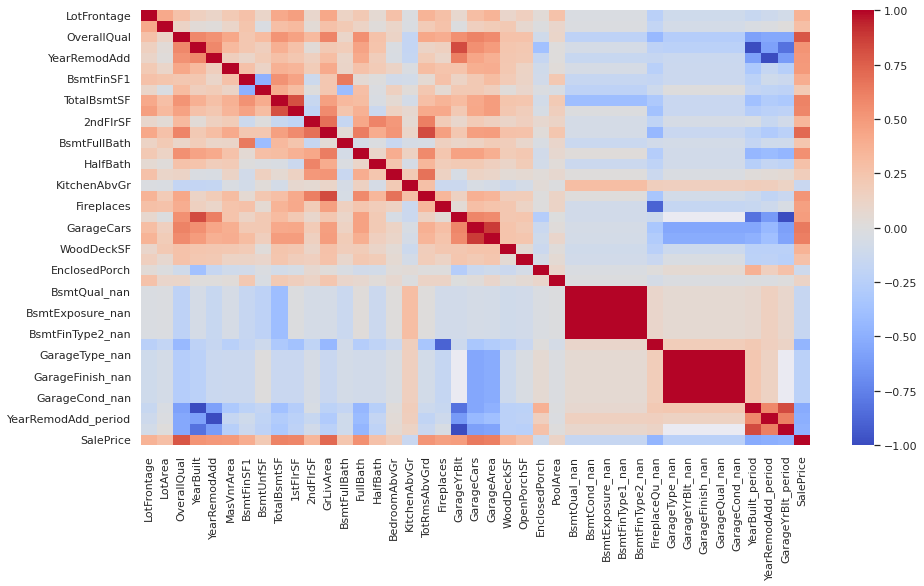

In [11]:
#Plotando mapa de calor a partir da matriz de correlações:
sb.set(rc = {'figure.figsize':(15,8)})
sb.heatmap(df_corr.corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm')

In [12]:
#def log_transform(x):
    #logx=np.log(x)
    #return logx

#log_transformer=FunctionTransformer(log_transform)
scaler=MinMaxScaler()
num_imputer=SimpleImputer(strategy='median')
cat_imputer=SimpleImputer(strategy='most_frequent')
ohe=OneHotEncoder()

numeric_transformer=Pipeline(steps=[('num_imputer', num_imputer), ('scaler', scaler)])
categoric_transformer=Pipeline(steps=[('cat_imputer', cat_imputer), ('encoding', ohe)])

preprocessing=ColumnTransformer(transformers=[('num', numeric_transformer, num_columns), ('cat', categoric_transformer, cat_columns)], remainder='passthrough')

In [13]:
regressor=LinearRegression()
feature_selector=SelectKBest(k=40, score_func=f_regression)
model=Pipeline(steps=[('preprocessing', preprocessing), ('feature selector', feature_selector), ('regressor', regressor)])

In [14]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                           

In [15]:
prediction=model.predict(X_test)


In [16]:
model.score(X_test, Y_test)

0.8125652015432409

In [17]:
X_test=pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv").iloc[:,:]
X_test=X_test.drop(["Id","Alley","PoolQC",'Fence','MiscFeature'],axis=1)
#Mesmo procedimento no dataset de teste:
for var in columns_na:
    X_test[var+'_nan']=np.where(X_test[var].isnull(), 1, 0)


#Mesmo procedimento no dataset de teste:
for var in date_columns:
    X_test[var+'_period']=X_test['YrSold']-X_test[var]

X_test.drop('YrSold_period', axis=1, inplace=True)

y_pred=model.predict(X_test)



In [18]:
y_pred=pd.DataFrame(y_pred)
X_id=pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv").iloc[:,0]
final2=pd.concat([X_id,y_pred],axis=1)
print(final2.head())

     Id         0
0  1461  107088.0
1  1462  156368.0
2  1463  179840.0
3  1464  193424.0
4  1465  195520.0


In [19]:
final2.to_csv("data12.csv",index=False)

In [20]:
data.to_csv("data1.csv",index=False)